In [1]:
%matplotlib inline
import numpy as np
import GP_regressors
import QGP_regressors
import time
import scipy 

from operator import itemgetter
import matplotlib.pyplot as plt
## latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 15})



In [2]:
##This function makes the plots easy  
def plot_with_uncertainty(Xp, mu, Sigma, color='r', title="", name = "Mean", linewidth=2.0, linestyle='-', marker = None):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    # plot distribution
    plt.plot(Xp, mean, color=color,  label=name, linewidth=linewidth, linestyle=linestyle, marker = marker)
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25)
    
    plt.title(title)

In [3]:
## Problem definition
## initial point
x_i = -np.pi
x_f = np.pi

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(np.sin(X_real))

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of trainning points
np.random.seed(24)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_t = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_t + np.random.normal(0.0, noise_std, size=y_t.shape)

sigma2 = noise_std**2

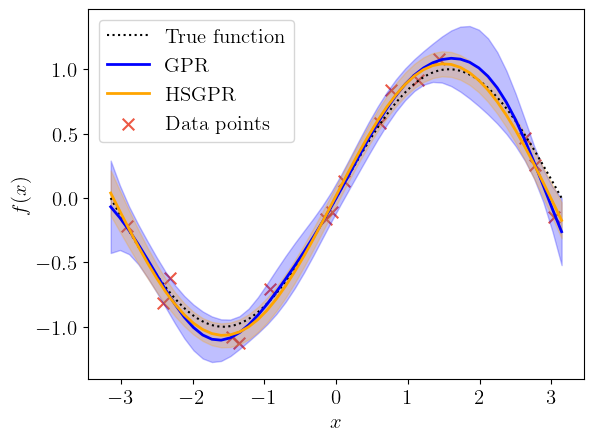

--- 0.6529717445373535 seconds ---


<Figure size 640x480 with 0 Axes>

In [4]:
#Models for regression
alpha = 1.5
scale = 1.0

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2*np.pi
M = 2**2

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)
import matplotlib.pyplot as plt


# Rest of your code for plotting

plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")

# Rest of your code for plotting



## GPR with exp kernel
plt.plot(X_real, y, label="True function", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GPR")
#plot_with_uncertainty(Xp, mu_post_approx_LP_k, Sigma_post_approx_LP_k, color='green', name = "Approximated LP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HSGPR")

plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()
# plot the graph in latex
plt.savefig("GPR_exp_kernel.pdf", bbox_inches='tight')

print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.012
#delta = 8.0

[0.51905967 0.11557984 0.03150868 0.33385182]


Real eigenvalues:  [0.51905967+0.j 0.11557984+0.j 0.03150868+0.j 0.33385182+0.j]
Quantum eigenvalues:  [0.5190667436102334, 0.33385709124424906, 0.11558586285213517, 0.03150573715431166]
Point:  1  of  50  done.
Point:  2  of  50  done.
Point:  3  of  50  done.
Point:  4  of  50  done.
Point:  5  of  50  done.
Point:  6  of  50  done.
Point:  7  of  50  done.
Point:  8  of  50  done.
Point:  9  of  50  done.
Point:  10  of  50  done.
Point:  11  of  50  done.
Point:  12  of  50  done.
Point:  13  of  50  done.
Point:  14  of  50  done.
Point:  15  of  50  done.
Point:  16  of  50  done.
Point:  17  of  50  done.
Point:  18  of  50  done.
Point:  19  of  50  done.
Point:  20  of  50  done.
Point:  21  of  50  done.
Point:  22  of  50  done.
Point:  23  of  50  done.
Point:  24  of  50  done.
Point:  25  of  50  done.
Point:  26  of  50  done.
Point:  27  of  50  done.
Point:  28  of  50  done.
Point:  29  of  50  done.
Point:  30  of  50  done.
Point:  31  of  50  done.
Point:  32  of  

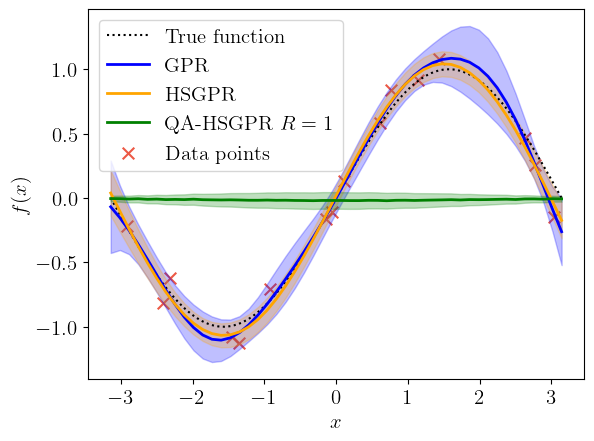

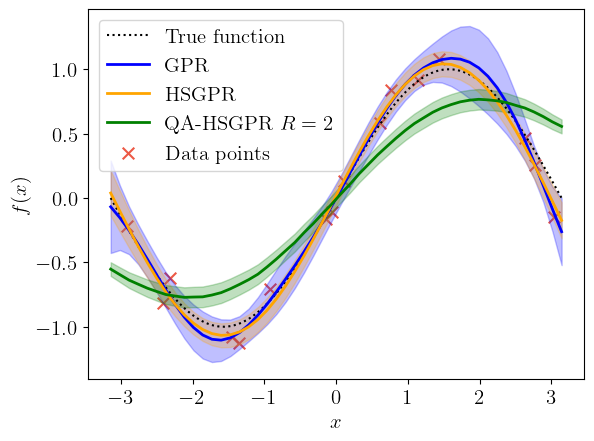

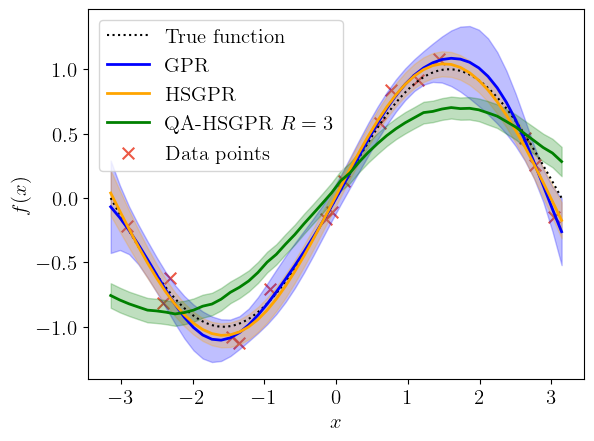

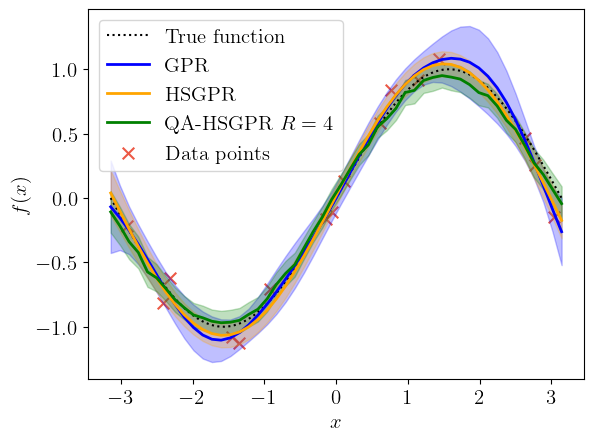

In [6]:
n_eig=13
shots = 1000000

## estimate for R = 1,2,3,4
for R in [1,2,3,4]:
    mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
    Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

    ## save the data in a txt file in columns, just the diagonal of the covariance matrix
    np.savetxt("Data/QAHSGPR_R{}_M{}_example_1.txt".format(R,M),
                np.c_[Xp, mu_post_exp_k, np.diag(Sigma_post_exp_k),
                mu_post_approx_HS_k, np.diag(Sigma_post_approx_HS_k),
                mu_post_approx_HS_k_QPU, np.diag(Sigma_post_approx_HS_k_QPU)], delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label="True function", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GPR")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HSGPR")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "QA-HSGPR $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/QAHSGP_R{}_M{}_example_1.pdf".format(R,M), bbox_inches='tight')

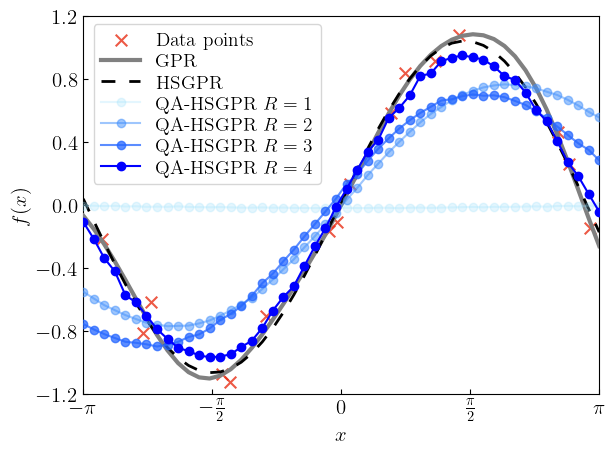

In [8]:
## colors for the plots
color_GPR = 'gray'
color_HSGPR = 'k'

## red
shades = ['#e66063', '#e35053', '#dd2c2f', '#d02224']

## Blue
shades = ['#97dffc', '#3f8efc', '#2667ff', '#0000ff']

R = 2

data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_1.txt".format(R,M), delimiter=",")
plt.figure()
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.plot(data[:,0], data[:,1], color=color_GPR, label="GPR", linewidth=3,zorder=5)

## place ticks inside figure
plt.tick_params(direction='in')



plt.ylim(-1.2,1.2)
plt.xlim(-np.pi,np.pi)

plt.yticks(np.arange(-1.2, 1.3, step=0.4))

tick_pos= [-np.pi , -np.pi/2, 0 , np.pi/2, np.pi]
labels = [r'$-\pi$', r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
plt.xticks(tick_pos, labels)

plt.tight_layout()

plt.savefig("Figures/mean_GPR_example_1.pdf")
## linestyle dashed more spaced
plt.plot(data[:,0], data[:,3], color=color_HSGPR, label="HSGPR",zorder=5, ls = '--', dashes=(5, 5), linewidth = 2.)


## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.32), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("Figures/mean_HSGPR_example_1.pdf")


Rs = [1,2,3,4]
for R in Rs:
    data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_1.txt".format(R,M), delimiter=",")
    plt.plot(data[:,0], data[:,5], 'o-', label="QA-HSGPR $R={}$".format(R), color=shades[R-1], alpha=(R/max(Rs))**1, zorder=5)
    ## place legend left 0.2 units
    plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

    plt.tight_layout()
    plt.savefig("Figures/mean_QHSGPR_R{}_example_1.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

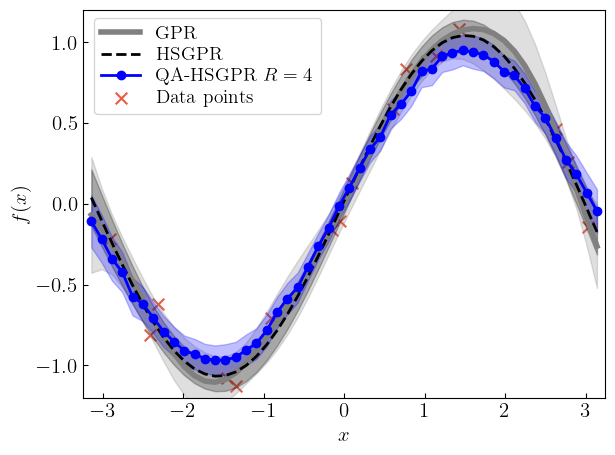

In [9]:
## plot te result with R = 4
R = 4
data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_1.txt".format(R,M), delimiter=",")

plot_with_uncertainty(Xp, data[:,1], np.diag(data[:,2]), color=color_GPR, name = "GPR", linestyle='-', linewidth=4.0)
plot_with_uncertainty(Xp, data[:,3], np.diag(data[:,4]), color=color_HSGPR, name = "HSGPR", linestyle='--')
plot_with_uncertainty(Xp, data[:,5], np.diag(data[:,6]), color=shades[-1], name = "QA-HSGPR $R={}$".format(R), linestyle='-', marker='o')
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()


## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

plt.ylim(-1.2,1.2)
plt.xlim(-np.pi-0.1,np.pi+0.1)

plt.tight_layout()

plt.savefig("Figures/mean_and_variance_QHSGPR_R{}_example_1.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

plt.show()

### Legendre polyomial estimation, M = 8

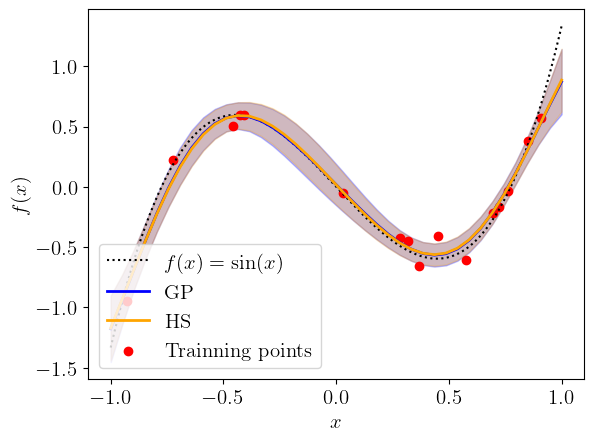

--- 0.12149429321289062 seconds ---


In [12]:
## initial point
x_i = -1
x_f = 1

X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze((5*(X_real)**3 - 3*(X_real))/1.5 )

## Points where we want to evaluate the function
Xp = np.linspace(start=x_i, stop=x_f, num=40).reshape(-1, 1)

## Number of trainning points
np.random.seed(2)
N_train =2**4

## Here some points of the function are randomnly chosen
training_indices = np.random.choice(np.arange(y.size), size=N_train, replace=False)
X_train, y_train = X_real[training_indices], y[training_indices]

## Noise addition, this is noise in the measurements
noise_std = 0.1
y_train = y_train + np.random.normal(0.0, noise_std, size=y_train.shape)

sigma2 = noise_std**2
#Models for regression

alpha = 1.0
scale = 0.5

start_time = time.time()

GK = GP_regressors.Gaussian_kernel_GPR((X_train, y_train),sigma2=sigma2, alpha=alpha, scale=scale)


L = 2
M = 2**3

HS = GP_regressors.HS_approx_GPR((X_train, y_train),
                   sigma2=sigma2,
                   M = M,
                   L = L,
                   alpha=alpha,
                   scale=scale)


mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## GPR with exp kernel
plt.figure()
plt.plot(X_real, y, label=r"$f(x) = \sin(x)$", linestyle="dotted", color='k')

plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GP")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HS")

plt.scatter(X_train, y_train, label="Trainning points", color='r')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [13]:
Phif = HS.Phi_matrix(X_train)
Lambda = HS.Lambda()
Phisf = HS.Phi_matrix(Xp).T


Z = np.array(Phif @ np.sqrt(Lambda))
Zs =np.array(Phisf.T @ np.sqrt(Lambda))

## Normalize the data
norm_z = np.linalg.norm(Z)

Z_norm = Z/norm_z

ZZd = np.array(Z_norm.T @ Z_norm)

real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)

## delta parameter should be 1>delta>lam_max
print( np.real(real_eigenvals))
delta =np.real(real_eigenvals[0])+0.01

## Presicion of eigenvalues should be greater than 4
n_eig=16
shots = 1E6

[5.70258371e-01 2.82914596e-01 1.04365848e-01 3.51231912e-02
 6.30237745e-03 9.58002439e-04 7.38727270e-05 3.74117084e-06]


In [14]:
## estimate for R = 2,3,4,5,6
Rs = [2,3,4,5,6]
for R in Rs:
    mean_args_post = [X_train, y_train, sigma2, M, L, alpha, scale, delta, n_eig, R, shots]
    mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU = QGP_regressors.QGPR_approximation_posterior(Xp,mean_args=mean_args_post)
    Sigma_post_approx_HS_k_QPU = np.diag(Sigma_post_approx_HS_k_QPU)

    ## save the data in a txt file in columns, just the diagonal of the covariance matrix
    np.savetxt("Data/QAHSGPR_R{}_M{}_example_2.txt".format(R,M),
                np.c_[Xp, mu_post_exp_k, np.diag(Sigma_post_exp_k),
                mu_post_approx_HS_k, np.diag(Sigma_post_approx_HS_k),
                mu_post_approx_HS_k_QPU, np.diag(Sigma_post_approx_HS_k_QPU)], delimiter=",")

    ## plot the results in independent figures
    plt.figure()
    plt.plot(X_real, y, label="True function", linestyle="dotted", color='k')
    plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GPR")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HSGPR")
    plot_with_uncertainty(Xp, mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, color='green', name = "QA-HSGPR $R={}$".format(R))

    plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()

    plt.savefig("Figures/QAHSGP_R{}_M{}_example_2.pdf".format(R,M), bbox_inches='tight')


Real eigenvalues:  [5.70258371e-01+0.j 2.82914596e-01+0.j 1.04365848e-01+0.j
 3.51231912e-02+0.j 6.30237745e-03+0.j 9.58002439e-04+0.j
 7.38727270e-05+0.j 3.74117084e-06+0.j]
Quantum eigenvalues:  [0.570262159792027, 0.2829131428545754, 0.10436257048874537, 0.03512397701950054, 0.0063040765409338, 0.0009562363292427674, 7.968636077023062e-05, 7.083232068464944e-05]
Point:  1  of  40  done.
Point:  2  of  40  done.
Point:  3  of  40  done.
Point:  4  of  40  done.
Point:  5  of  40  done.
Point:  6  of  40  done.
Point:  7  of  40  done.
Point:  8  of  40  done.
Point:  9  of  40  done.
Point:  10  of  40  done.
Point:  11  of  40  done.
Point:  12  of  40  done.
Point:  13  of  40  done.
Point:  14  of  40  done.
Point:  15  of  40  done.
Point:  16  of  40  done.
Point:  17  of  40  done.
Point:  18  of  40  done.
Point:  19  of  40  done.
Point:  20  of  40  done.
Point:  21  of  40  done.
Point:  22  of  40  done.
Point:  23  of  40  done.
Point:  24  of  40  done.
Point:  25  of  4

ValueError: not enough values to unpack (expected 3, got 2)

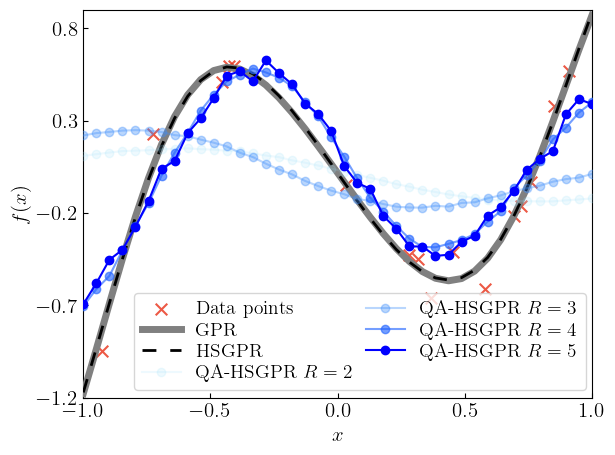

In [ ]:
plt.rcParams.update({'font.size': 15})

## colors for the plots
color_GPR = 'gray'
color_HSGPR = 'k'

## red
shades = ['#e66063', '#e35053', '#dd2c2f', '#d02224']

## Blue
shades = ['#97dffc', '#3f8efc', '#2667ff', 'blue']
R = 2
data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_2.txt".format(R,M), delimiter=",")
plt.figure()
plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.plot(data[:,0], data[:,1], color=color_GPR, label="GPR", linewidth=5,zorder=5)

## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.32), loc='upper left', borderaxespad=0.)

plt.ylim(-1.2,0.9)
plt.xlim(-1.,1.)

## x ticks interval f 0.5
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1.2, 0.9, step=0.5))
plt.tight_layout()

plt.savefig("Figures/mean_GPR_example_2.pdf")
plt.plot(data[:,0], data[:,3], color=color_HSGPR, label="HSGPR",zorder=5, ls = '--', dashes=(5, 5), lw = 2)


## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.15, 0.2), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("Figures/mean_HSGPR_example_2.pdf")


Rs = [2,3,4,5]
for R in Rs:
    data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_2.txt".format(R,M), delimiter=",")
    plt.plot(data[:,0], data[:,5], 'o-',label="QA-HSGPR $R={}$".format(R), color=shades[R-2], alpha=(R/max(Rs))**2, zorder=5)
    ## place legend left 0.2 units
    plt.legend(bbox_to_anchor=(0.1, 0.02), loc='lower left', fontsize = 14, borderaxespad=0.,ncol=2,labelspacing=0.2,  columnspacing=0.6)

    plt.tight_layout()
    plt.savefig("Figures/mean_QHSGPR_R{}_example_2.pdf".format(R),  pad_inches = 0, bbox_inches='tight')



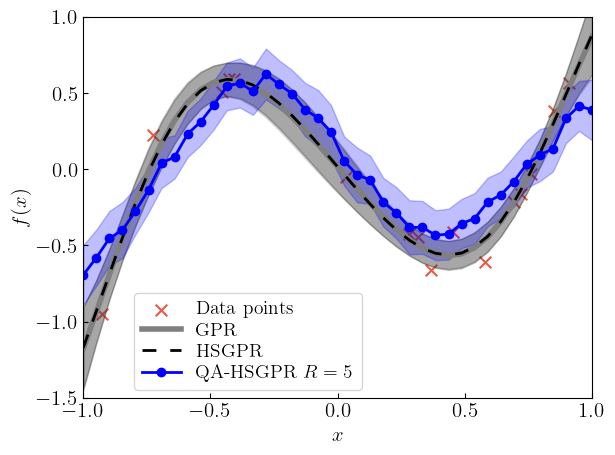

In [ ]:
## plot te result with R = 4
R = 4
data = np.loadtxt("Data/QAHSGPR_R{}_M{}_example_2.txt".format(R,M), delimiter=",")

plt.scatter(X_train, y_train, marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)
plot_with_uncertainty(Xp, data[:,1], np.diag(data[:,2]), color=color_GPR, name = "GPR", linewidth=4.0, linestyle='solid')
plot_with_uncertainty(Xp, data[:,3], np.diag(data[:,4]), color=color_HSGPR, name = "HSGPR", linestyle=(0, (5, 5)), linewidth=2.0)
plot_with_uncertainty(Xp, data[:,5], np.diag(data[:,6]), color=shades[-1], name = "QA-HSGPR $R={}$".format(R),linestyle='-' ,marker='o')


plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()


## place ticks inside figure
plt.tick_params(direction='in')

## place legend left 0.2 units
plt.legend(bbox_to_anchor=(0.1, 0.02), loc='lower left', fontsize = 14, borderaxespad=0.,ncol=1,labelspacing=0.2,  columnspacing=0.6)

plt.ylim(-1.5,1.)
plt.xlim(-1.,1.)

## x ticks interval f 0.5
plt.xticks(np.arange(-1, 1.1, step=0.5))
plt.yticks(np.arange(-1.5, 1.2, step=0.5))
plt.tight_layout()

plt.savefig("Figures/mean_and_variance_QHSGPR_R{}_example_2.pdf".format(R),  pad_inches = 0, bbox_inches='tight')

plt.show()
